# Обучение с учителем: качество модели

## Подготовка к работе над проектом

### Описание проекта

In [220]:
!ls

7ac2572b-a8e6-454b-8798-1b1540012dd2.ipynb
market_file.csv
market_money.csv
market_time.csv
money.csv


В контексте проекта для интернет-магазина "В один клик", который сталкивается с снижением активности покупателей, целью стажировки в отделе цифровых технологий является разработка решения для удержания постоянных клиентов путем персонализации предложений.

В связи с тем, что привлечение новых клиентов становится менее эффективным, руководство магазина приходит к выводу, что более эффективным подходом будет удержание уже существующей аудитории. Для этого предлагается использовать персонализированные предложения, анализируя данные о покупках и предпочтениях клиентов.

Основная задача заключается в построении модели, предсказывающей вероятность снижения покупательной активности клиента в следующие три месяца и определении параметров, наиболее сильно на это влияющих. На основе проведенного анализа и данных о прибыльности клиентов требуется провести сегментацию пользователей и предложить варианты увеличения их покупательной активности.

Для исследования представлены четыре датасета:

`market_file.csv`    
`market_money.csv`    
`market_time.csv`    
`money.csv`

**Цель проекта:** увеличить покупательскую активность постоянных клиентов путем предоставления им персонализированных предложений, что в конечном итоге должно привести к увеличению выручки интернет-магазина "В один клик".

**Ход исследования:**
- предобработка данных (проверить данные на наличие дубликатов и пропусков);
- исследовательсий анализ данных (избавиться от аномальных значений);
- корреляционный анализ данных (определить, какие признаки стоит использовать при обучении моделей);
- использование пайплайнов;
- выбор лучшей модели и её гиперпараметров;
- анализ важности признаков;
- сегментация покупателей.

### Импорт библиотек

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

!pip install phik -q
from phik.report import plot_correlation_matrix
from phik import report

!pip install --upgrade scipy scikit-learn jupyter

try:
    import shap
except ImportError:
    !pip install shap
    import shap

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="scipy")

In [7]:
# показывать все колонки датафреймов
pd.set_option('display.max_columns', None)

### Добавление функций

In [9]:
# функция для вывода общей информации о датафрейме
def df_review(df):
    display(df.head())
    df.info()
    display(df.describe())

In [10]:
def pivot_bar_plot(df, index_column, title):
    # Создание сводной таблицы
    pivot_table = df.pivot_table(values='id', index=index_column, aggfunc='count')
    pivot_table.rename(columns={'id': f'{index_column}_count'}, inplace=True)
    display(pivot_table)
    
    # Построение бар-плота
    plt.figure(figsize=(10, 4))
    plt.barh(pivot_table.index, pivot_table[f'{index_column}_count'])
    plt.xlabel(f'{index_column} count')
    plt.ylabel(index_column)
    plt.title(title)
    plt.show()

### Загрузка данных

In [12]:
# импорт полученных для анализа датафреймов
market_file = pd.read_csv('market_file.csv', sep=',')
market_money = pd.read_csv('market_money.csv', sep=',')
market_time = pd.read_csv('market_time.csv', sep=',')
money = pd.read_csv('money.csv', sep=';', decimal=',')

## Предобработка данных

### Работа над датасетом `market_file`

Выведем информацию о датасете `market_file`.

In [16]:
df_review(market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Создадим словарь и переименуем названия колонок, используя латиницу и змеинный регистр.

In [18]:
col_name_market_file = {
    'id': 'id', 
    'Покупательская активность': 'buying_activity', 
    'Тип сервиса': 'service_type',
    'Разрешить сообщать': 'allow_report',
    'Маркет_актив_6_мес': 'market_activ_6_mon', 
    'Маркет_актив_тек_мес': 'market_activ_cur_mon', 
    'Длительность': 'days_since_reg',
    'Акционные_покупки': 'promo', 
    'Популярная_категория': 'top_cat_6M',
    'Средний_просмотр_категорий_за_визит': 'mean_view_cat_per_visit',
    'Неоплаченные_продукты_штук_квартал': 'unpaid_goods_per_quarter', 
    'Ошибка_сервиса': 'service_error',
    'Страниц_за_визит': 'webpage_per_visit'
}

market_file.rename(columns=col_name_market_file, inplace=True)

In [19]:
market_file.head()

,id,buying_activity,service_type,allow_report,market_activ_6_mon,market_activ_cur_mon,days_since_reg,promo,top_cat_6M,mean_view_cat_per_visit,unpaid_goods_per_quarter,service_error,webpage_per_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**Промежуточный вывод**   
Датафрейм содержит 1300 строк, данные распределены по 13 колонкам. Очевидных пропусков нет. Типы данных менять не нужно. Поменяли названия колонок и привели их тем самым к единому стилю.

### Работа над датасетом `market_money`

Выведем информацию о датасете `market_money`.

In [23]:
df_review(market_money)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Проверим значения, которые содержатся в колонках с типом данных `object`.

In [25]:
for i in market_money:
    if market_money[i].dtype == 'object':
        print(i, ':')
        display(market_money[i].unique())

Период :


array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Поменяем вид датасета таким образом, чтобы в индексах были id.

In [27]:
market_money = market_money.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='sum').reset_index()
market_money.columns.name = None
market_money.columns = ['id', 'last_rev', 'last_last_rev', 'current_rev']

Поменяем местами колонки с выручкой за предпредыдущий и предыдущий месяцы.

In [29]:
cols = list(market_money.columns)
cols[1], cols[2] = cols[2], cols[1]
market_money = market_money[cols]

Выведем преобразованный датасет и его размер.

In [31]:
display(market_money.head())
market_money.shape

,id,last_last_rev,last_rev,current_rev
0,215348,0.0,0.0,3293.1
1,215349,4472.0,5216.0,4971.6
2,215350,4826.0,5457.5,5058.4
3,215351,4793.0,6158.0,6610.4
4,215352,4594.0,5807.5,5872.5


(1300, 4)

**Промежуточный вывод**   
Изначально датасет содержал 3900 строки, данные были распределены по 3 колонкам. Затем мы изменили вид таблицы, чтобы id стали индексами. Новый размер таблицы составляет 1300 строк, распределённых по 4 столбцам. Очевидных пропусков нет. Типы данных менять не нужно. Поменяли названия колонок и привели их тем самым к единому стилю.

### Работа над датасетом `market_time`

Выведем информацию о датасете `market_time`.

In [35]:
df_review(market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Сделаем то же самое с датасетов `market_time`, что мы сделали с `market_money`.

In [37]:
market_time = market_time.pivot_table(index='id', columns='Период', values='минут', aggfunc='sum').reset_index()
market_time.columns.name = None
market_time.columns = ['id', 'last_month_min_sum', 'current_month_min_sum']

In [38]:
display(market_time.head())
market_time.shape

,id,last_month_min_sum,current_month_min_sum
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


(1300, 3)

**Промежуточный вывод**   
Изначально датасет содержал 2600 строк, данные были распределены по 3 колонкам. Затем мы изменили вид таблицы, чтобы id стали индексами. Новый размер таблицы составляет 1300 строк, распределённых по 3 столбцам. Очевидных пропусков нет. Типы данных менять не нужно. Поменяли названия колонок и привели их тем самым к единому стилю.

### Работа над датасетом `money`

Выведем информацию о датасете `money`.

In [42]:
df_review(money)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


In [43]:
money.columns = ['id', 'avg_3_mon_revenue']

**Промежуточный вывод**   
Датафрейм содержит 1300 строки, данные распределены по 2 колонкам. Очевидных пропусков нет. Типы данных менять не нужно. Поменяли название колонки "Прибыль" и привели таблицу тем самым к единому стилю.

### Работа с дубликатами

#### Явные дубликаты

In [47]:
def print_duplicates_count(*dfs, names):
    for df, name in zip(dfs, names):
        # Подсчёт дубликатов
        duplicates_count = df.duplicated(keep=False).sum()
        print(f"Количество дубликатов в {name}: {duplicates_count}")

# Вызов функции для проверки четырех DataFrame
print_duplicates_count(market_file, market_money, market_time, money, 
                       names=["market_file", "market_money", "market_time", "money"])

Количество дубликатов в market_file: 0
Количество дубликатов в market_money: 0
Количество дубликатов в market_time: 0
Количество дубликатов в money: 0


#### Неявные дубликаты

Проверим датасет `market_file` на наличие неявных дубликатов, так как в нём есть значения с типом данных `object`.

In [50]:
for i in market_file:
    if market_file[i].dtype == 'object':
        print(i, ':')
        display(market_file[i].unique())

buying_activity :


array(['Снизилась', 'Прежний уровень'], dtype=object)

service_type :


array(['премиум', 'стандартт', 'стандарт'], dtype=object)

allow_report :


array(['да', 'нет'], dtype=object)

top_cat_6M :


array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Исправим опечатку одного из значений `service_type`.

In [52]:
market_file['service_type'] = market_file['service_type'].replace({'стандартт':'стандарт'},regex=True).str.lower()

### Вывод

Мы загрузили файлы и рассмотрели данные.
1. датафрейм `market_file` включает в себя 1300 строк, данные разбиты на 13 колонок, которые мы переимновали, тем самым приведя к единому стилю:    
- `id` - номер покупателя в корпоративной базе данных;    
- `buying_activity` - рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень»;    
- `service_type` - уровень сервиса, например «премиум» и «стандарт»;    
- `allow_report` - информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель;   
- `market_activ_6_mon` - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента;    
- `market_activ_cur_mon` - количество маркетинговых коммуникаций в текущем месяце;    
- `days_since_reg` - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте;   
- `promo` - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;    
- `top_cat_6M` - самая популярная категория товаров у покупателя за последние 6 месяцев;    
- `mean_view_cat_per_visit` - показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца;    
- `unpaid_goods_per_quarter` - общее число неоплаченных товаров в корзине за последние 3 месяца;
- `service_error` - число сбоев, которые коснулись покупателя во время посещения сайта;
- `webpage_per_visit` - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

2. датафрейм `market_money` включает в себя 1300 строк, данные разбиты на 4 колонки:
- `id` - номер покупателя в корпоративной базе данных;
- `last_last_rev` - выручка за предпредыдущий месяц;
- `last_rev` - выручка за предыдущий месяц;
- `current_rev` - выручка за текущий.

3. датафрейм `market_time` включает в себя 1300 строк, данные разбиты на 3 колонки:
- `id` - номер покупателя в корпоративной базе данных;
- `last_month_min_sum` - время в минутах, проведённое на сайте за прошлый месяц;
- `current_month_min_sum` - время в минутах, проведённое на сайте за текущий месяц. 

4. датафрейм `money` включает в себя 1300 строк, данные разбиты на 2 колонки:
- `id` - номер покупателя в корпоративной базе данных;
- `avg_3_mon_revenue` - среднемесячная прибыль покупателя за последние 3 месяца.

Пропусков в данных нет. Все типы данных представлены в датафреймах верно.

## Исследовательский анализ данных

### Данные с количественными значениями датафрейма `market_file`

Построим гистограммы для всех колонок с количественными значениями.

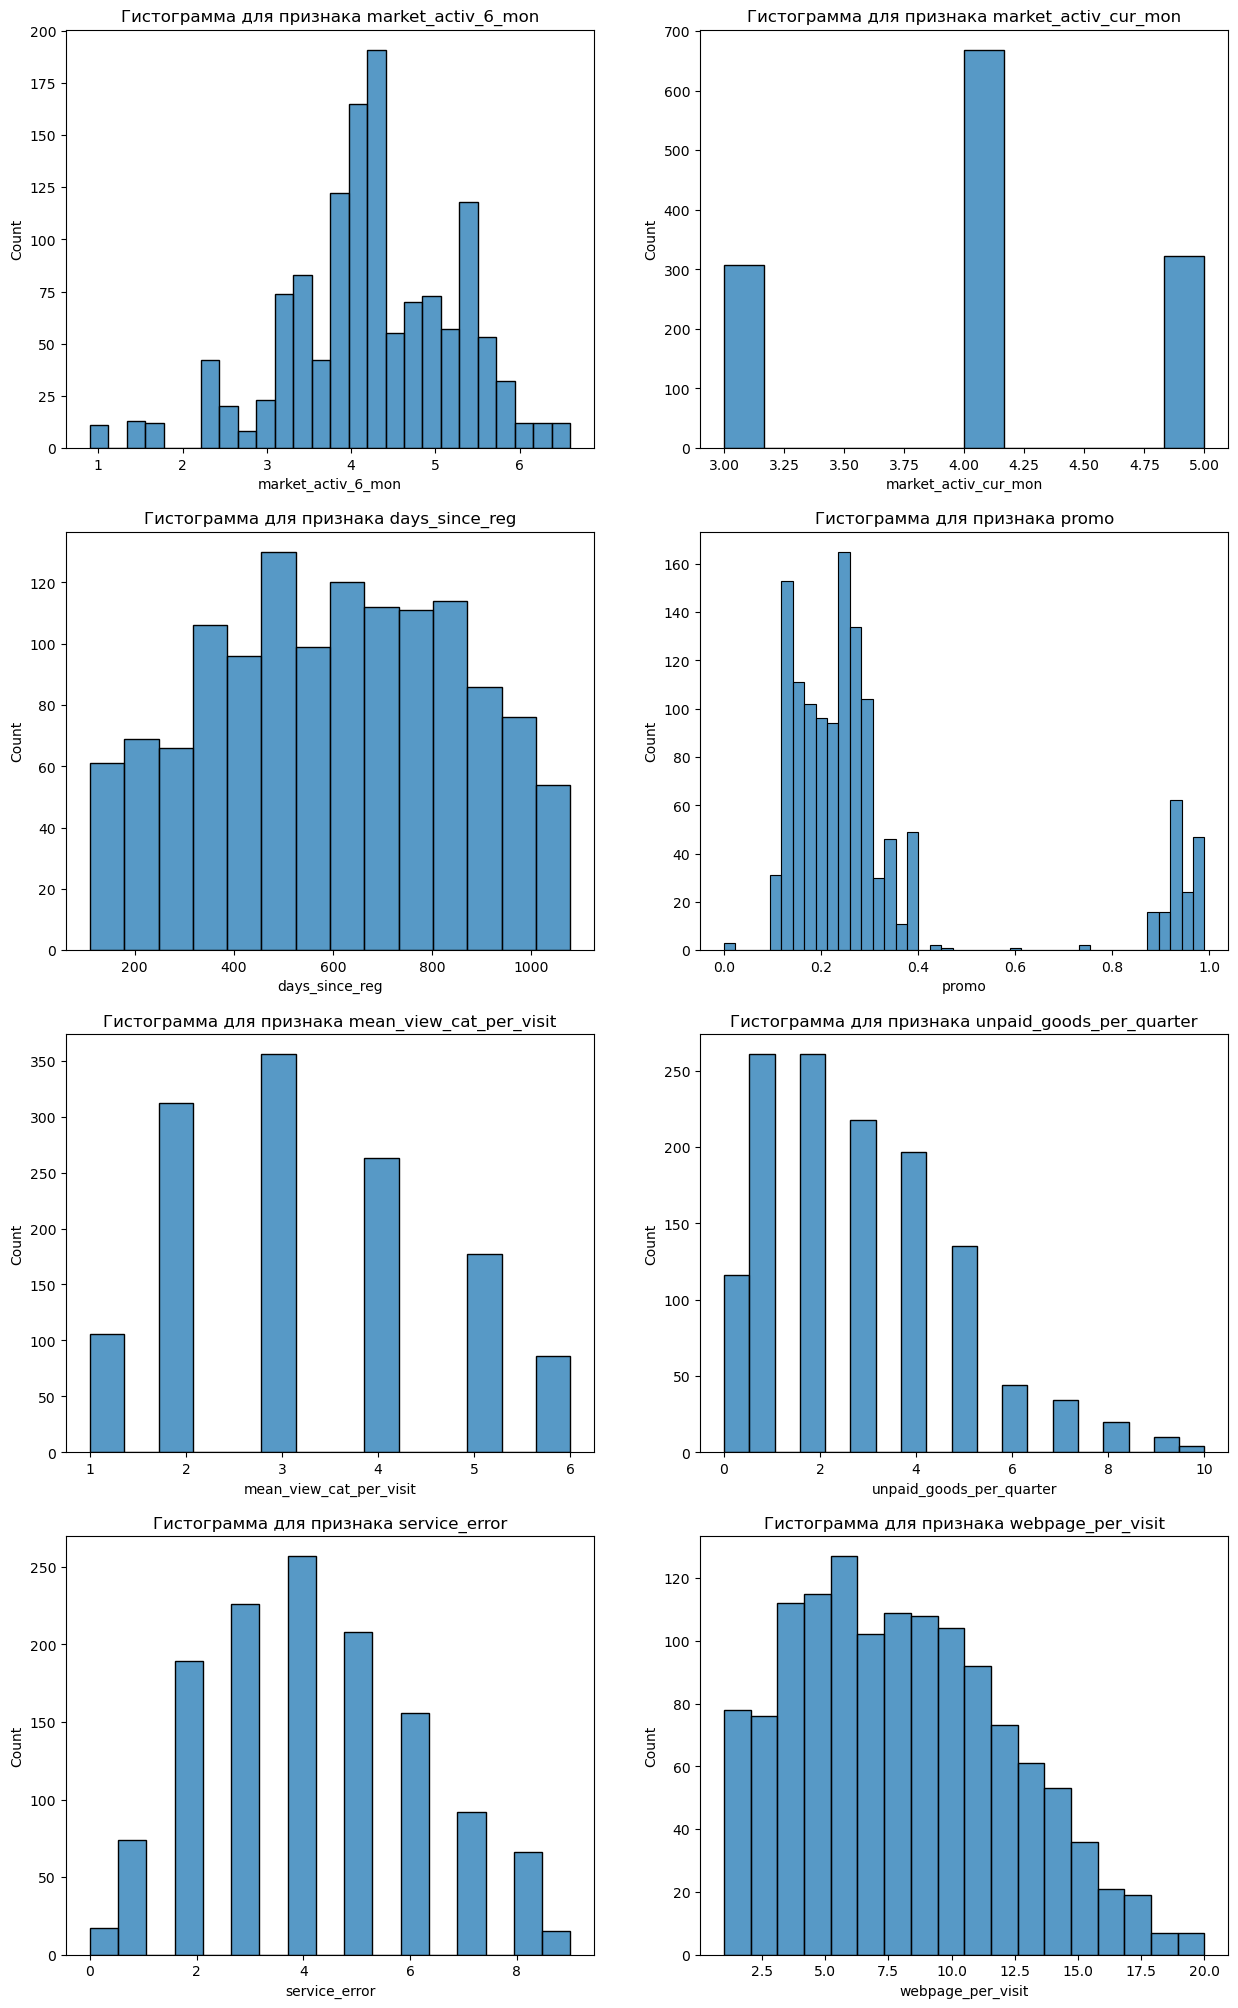

In [58]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 25))

col_hist = market_file[['market_activ_6_mon', 'market_activ_cur_mon', 
                        'days_since_reg', 'promo', 'mean_view_cat_per_visit', 
                        'unpaid_goods_per_quarter', 'service_error', 
                        'webpage_per_visit']]

# Перебор признаков и построение гистограммы для каждого
for i, col in enumerate(col_hist):
    sns.histplot(market_file[col], ax=axes[i//2, i%2])  # Распределение значений столбца col
    axes[i//2, i%2].set_title(f'Гистограмма для признака {col}')


plt.show()

На графиках видно, что все параметры распределены реалистично, и очевидных аномалий в данных нет.
Любопытным может показаться график распределения параметра `promo`, указывающего долю акционных покупок – у графика есть "хвост", сильно удаленный от среднего значения. Однако, учитывая специфику сферы эта форма графика выглядит абсолютно объяснимо: часть пользователей интернет-магазина покупают преимущественно акционные товары, что очень распространено в сфере онлайн-продаж.

Построим бокс-плоты для уточнения картинок распределения.

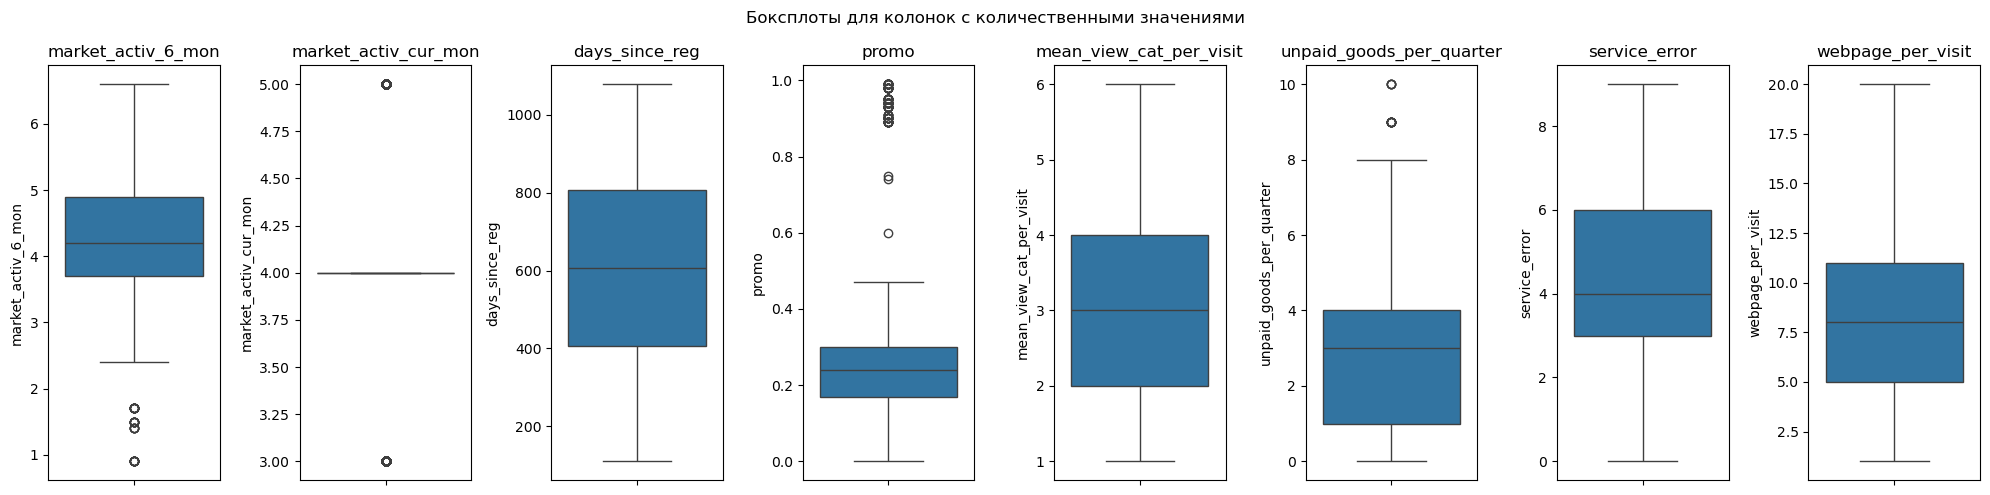

In [61]:
numeric_columns = market_file[['market_activ_6_mon', 'market_activ_cur_mon', 
                        'days_since_reg', 'promo', 'mean_view_cat_per_visit', 
                        'unpaid_goods_per_quarter', 'service_error', 
                        'webpage_per_visit']]

fig, axes = plt.subplots(nrows=1, ncols=len(numeric_columns.columns), figsize=(20, 5))

for i, column in enumerate(numeric_columns.columns):
    sns.boxplot(y=numeric_columns[column], ax=axes[i])
    axes[i].set_title(column)

plt.suptitle('Боксплоты для колонок с количественными значениями')
plt.tight_layout()
plt.show()

На представленных бокс-плотах видно, что часть параметров, такие как `days_since_reg`, `mean_view_cat_per_visit`, `service_error` и `webpage_per_visit` не имеют точек, похожих на выбросы. 

Для других параметров на диаграммах видны значения, похожие на выбросы. 

- `market_activ_6_mon` - количество коммуникаций на пользователя в последние 6 месяцев – имеет аномальные значения, близкие к нулю. Данная аномалия может объясняться тем, что часть пользователей могла отказаться от рассылки после первых нескольких полученных коммуникаций.
- `market_activ_cur_mon` - количество коммуникаций на пользователя в текущем месяце – имеет очень дискретное распределение, которое может объясняться внутренними ограничениями в компании (например, у CRM отдела есть KPI отправлять не менее 3х коммуникаций на пользователя, но ограничение, что коммуникаций не должно быть больше 5 в месяц).
- `promo`- доля акционных товаров в покупках пользователя – имеет "хвост" распределения, который, как указано выше, специфичен для сферы онлайн-продаж, т.к. немало пользователей покупает преимущественно товары со скидками, игнорируя товары за полную стоимость за исключением случаев крайней необходимости.
- `unpaid_goods_per_quarter`- число неоплаченных товаров за последний квартал – принимает для некоторых пользователей значения, который можно принять за выбросы. Учитывая разброс значений этого параметра (от 0 до 10) и величину значения потенциальных выбросов (от 8 до 10) мы также можем заключить, что данные значния абсолютно реальны и скорее всего не являются аномалиями в данных.

**Выводы по диаграммам:**

По построенным выше диаграммам можно сделать вывод, что в данных о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении нет аномалий, который могли бы препятствовать дальнейшей работе с данными.

### Данные с категориальными значениями датафрейма `market_file`

,buying_activity_count
buying_activity,
Прежний уровень,802
Снизилась,498


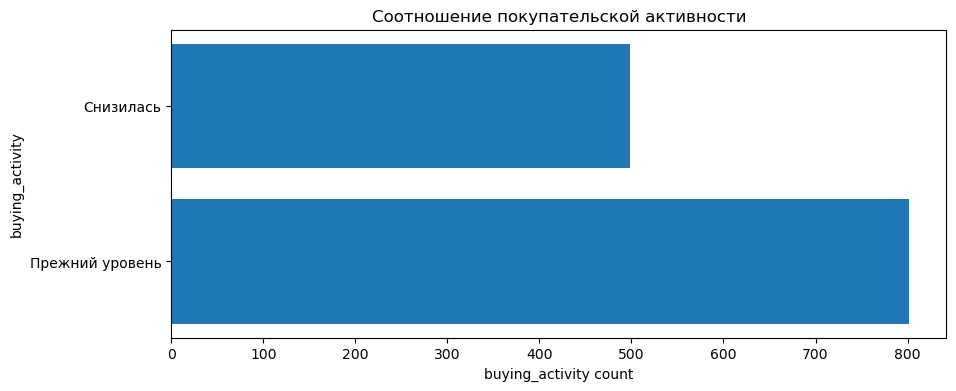

In [65]:
pivot_bar_plot(market_file, 'buying_activity', 'Соотношение покупательской активности')

Данные покупательской активности соответствуют заявленной проблеме: на графике видно, что активность порядка трети покупаетей снизилась. 

,service_type_count
service_type,
премиум,376
стандарт,924


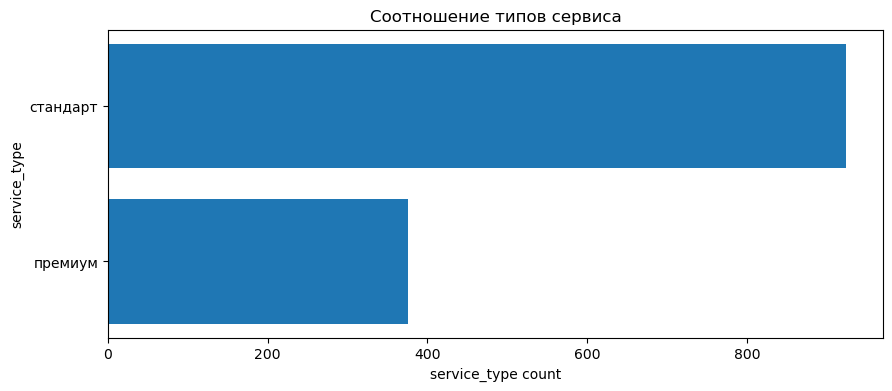

In [67]:
pivot_bar_plot(market_file, 'service_type', 'Соотношение типов сервиса')

По распределению типов сервиса можно отметить, что уровень "премиум" доступен не более, чем трети клиентов онлайн-магазина

,allow_report_count
allow_report,
да,962
нет,338


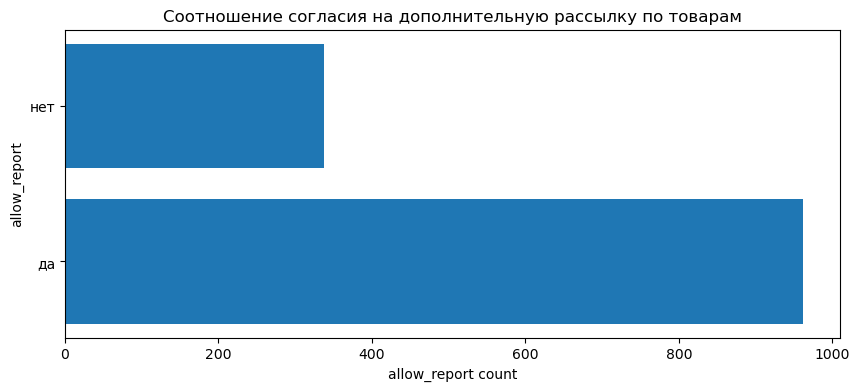

In [69]:
pivot_bar_plot(market_file, 'allow_report', 'Соотношение согласия на дополнительную рассылку по товарам')

Также заметим, что большая часть пользователей (порядка трех четвертей) дали согласие на коммуникации о дополнительных предложениях.

,top_cat_6M_count
top_cat_6M,
Домашний текстиль,251
Косметика и аксесуары,223
Кухонная посуда,138
Мелкая бытовая техника и электроника,174
Техника для красоты и здоровья,184
Товары для детей,330


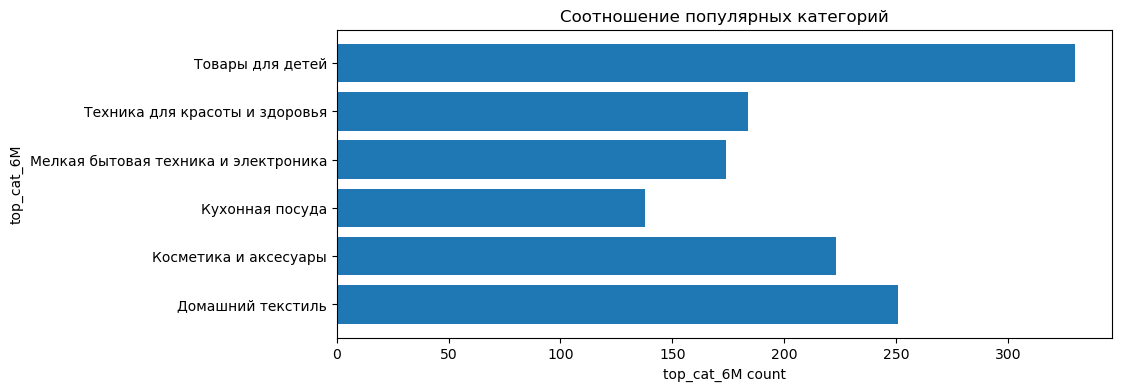

In [71]:
pivot_bar_plot(market_file, 'top_cat_6M', 'Соотношение популярных категорий')

По диаграмме соотношения популярных категорий видно следующее:

- "товары для детей" являются самой популярной категорией товаров для наибольшей группы покупаетей,
- тройку самых частых популярных категорий дополняют "домашний текстиль" и "косметика и аксессуары",
- "кухонная посуда" являтся самым редким "фаворитом" среди категорий - она является самой популярной категорией всего для примерно 10% пользователей.

### Данные с количественными значениями датафрейма `market_money`

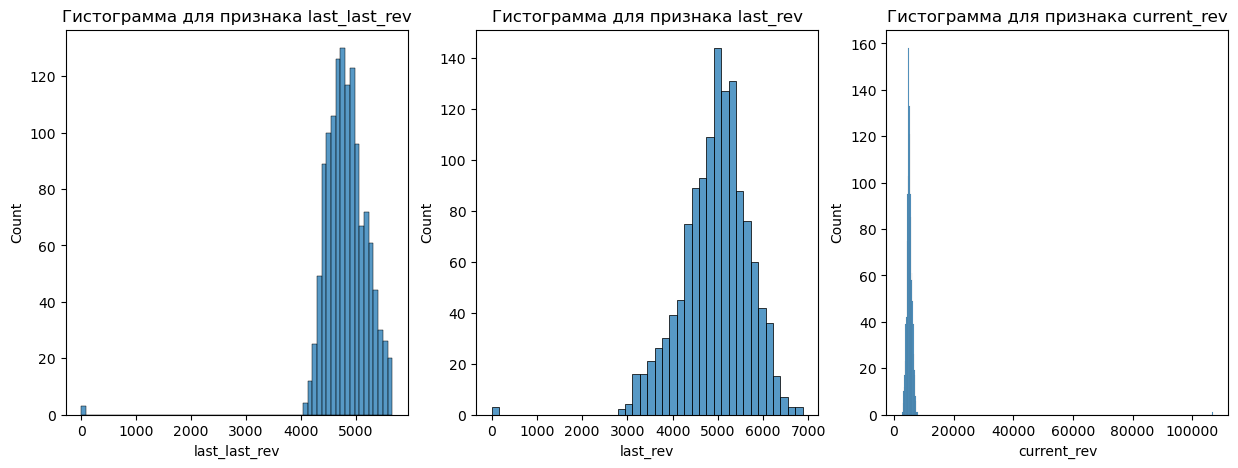

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

col_hist = market_money[['last_last_rev', 'last_rev', 'current_rev']]

# Перебор признаков и построение гистограммы для каждого
for i, col in enumerate(col_hist):
    sns.histplot(market_money[col], ax=axes[i])  # Распределение значений столбца col
    axes[i].set_title(f'Гистограмма для признака {col}')

plt.show()

По данным о выручке видно, что большая часть пользователей приносила в среднем порядка 5000 руб выручки компании в предпредыдущем и предыдущем месяцах, с небольшим количеством пользователей, вообще не потративших денег в интернет-магазине за эти периоды. Данное распределение выглядит реалистично для рассматриваемой сферы.

Обратим отдельное внимания на график выручки за текущий месяц.     
По форме графика можно заподозрить аномалию в районе значения `100 000`. Рассмотрим эти данные подробнее. 

In [76]:
market_money['current_rev'].describe([0.25, 0.5, 0.75, 0.90, 0.99, 0.999])

count      1300.000000
mean       5314.960846
std        2939.708156
min        2758.700000
25%        4706.050000
50%        5179.950000
75%        5761.725000
90%        6368.940000
99%        7314.114000
99.9%      7741.364100
max      106862.200000
Name: current_rev, dtype: float64

In [77]:
market_money[market_money['current_rev'] >= 7800]

,id,last_last_rev,last_rev,current_rev
32,215380,5051.0,6077.0,106862.2


In [78]:
market_money.drop(32, axis=0, inplace=True)

Более подробный анализ показывает, что по данным из таблицы `market_money` пользователь с `id = 215380` потратил 106 862.2 рубля, что является либо реальным, но аномальным поведением, либо ошибкой в данных. 
Такое значение может мешать обучению модели, поэтому его требуется удалить или заменить на среднее для этого пользователя за предыдущие периоды.      

В данном случае было принято решение удалить данные об этом пользователе, и не использовать их в дальнейшей работе. 

### Данные с количественными значениями датафрейма `market_time`

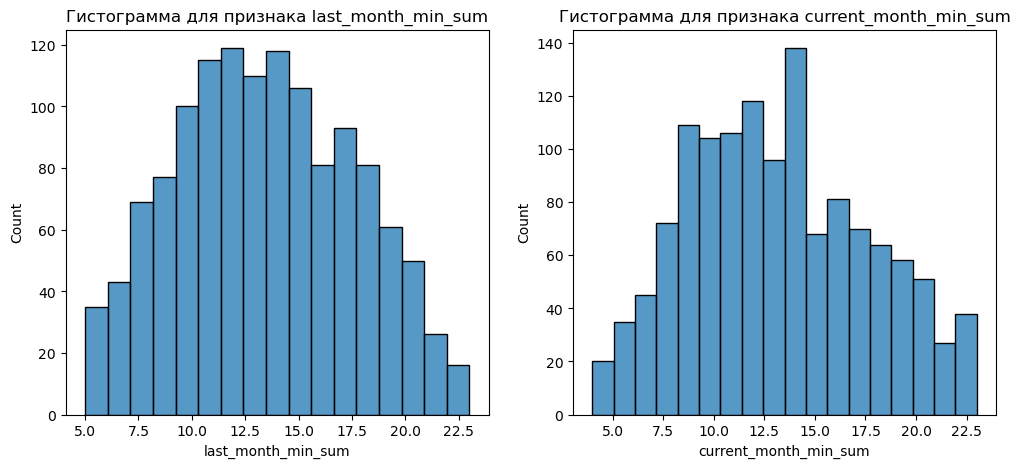

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

col_hist = market_time[['last_month_min_sum','current_month_min_sum']]

for i, col in enumerate(col_hist):
    sns.histplot(market_time[col], ax=axes[i])  
    axes[i].set_title(f'Гистограмма для признака {col}')

plt.show()

По построенным гистограммам видно, что значения в таблице о времени, проведенном покупателями на сайте, распределены реалистично и их распределение близко к нормальному.

Работа с аномальными значениями не требуется.

### Данные с количественными значениями датафрейма `money`

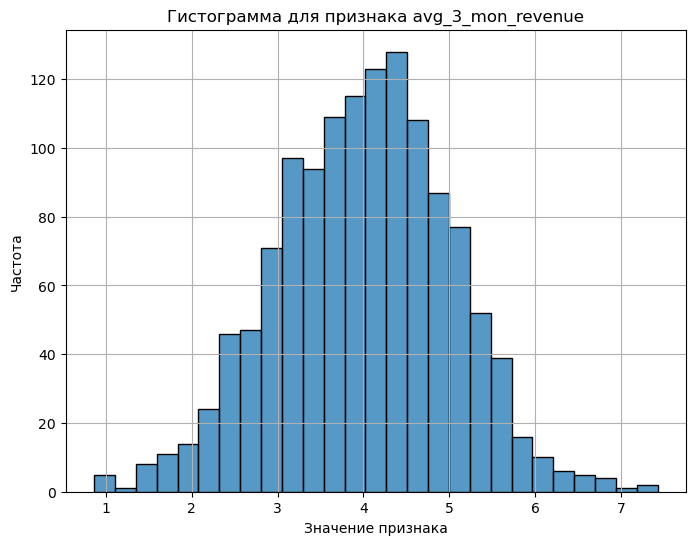

In [84]:
# Выбор одного признака для построения гистограммы
feature = 'avg_3_mon_revenue'

# Построение гистограммы
plt.figure(figsize=(8, 6))
sns.histplot(money[feature])
plt.title(f'Гистограмма для признака {feature}')
plt.xlabel('Значение признака')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Значения прибыли магазина с покупателей имеют распределение близкое к нормальному, без каких-либо выбросов или аномалий.

### Общий вывод

В процессе исследовательского анализа данных в представленных датафреймах было выявлено только одно аномальное значение в файле `market_money`. Данное значение было удалено, т.к. является либо нетипичным поведением, не релевантным для обучения модели, либо ошибкой в данных.
После удаления аномального значения все признаки распределены реалистично, большая часть количественных признаков имеет распределение близкое к нормальному.

Данные пригодны для дальнейшей работы. 

## Объединение датасетов

Объединим датафреймы, помня, что мы удалили одно значение в датафрейме `market_money`.

In [89]:
df = market_file.merge(market_money, how='right', on='id')\
    .merge(market_time, how='left', on='id')

In [90]:
data_info = [(market_file, 'market_file'), (market_money, 'market_money'), (market_time, 'market_time')]
for data, name in data_info:
    print(f'Строк в {name}: {len(data)}')
    print(f'Пользователей в {name}: {len(data["id"].unique())}')

Строк в market_file: 1300
Пользователей в market_file: 1300
Строк в market_money: 1299
Пользователей в market_money: 1299
Строк в market_time: 1300
Пользователей в market_time: 1300


In [91]:
display(df.head())
df.shape

,id,buying_activity,service_type,allow_report,market_activ_6_mon,market_activ_cur_mon,days_since_reg,promo,top_cat_6M,mean_view_cat_per_visit,unpaid_goods_per_quarter,service_error,webpage_per_visit,last_last_rev,last_rev,current_rev,last_month_min_sum,current_month_min_sum
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11


(1299, 18)

Отберём клиентов с покупательской активностью не менее трёх месяцев, то есть тех, кто покупал что-то в этот период.

In [93]:
df = df.query('last_last_rev !=0 & last_rev !=0 & current_rev!=0')

In [94]:
display(df.head())
df.shape

,id,buying_activity,service_type,allow_report,market_activ_6_mon,market_activ_cur_mon,days_since_reg,promo,top_cat_6M,mean_view_cat_per_visit,unpaid_goods_per_quarter,service_error,webpage_per_visit,last_last_rev,last_rev,current_rev,last_month_min_sum,current_month_min_sum
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


(1296, 18)

In [95]:
df.set_index('id', inplace=True)

**Вывод:**    
Мы объединили датафреймы `market_file`, `market_money`, `market_time` в один датафрейм `df`. Также мы избавились для дальнейшего исследования от тех пользователей, у которых не наблюдалось активности за последние три месяца. Таким образом, датафрейм `df`состоит из 1296 строк и 18 столбцов.

## Корреляционный анализ

На данном этапе мы изучим взаимосвязь признаков для того, чтобы потом успешно применить наши знания для создания и обучения моделей МО.

Построим матрицу корреляции для датафрейма `df`.

In [100]:
interval_cols = ['market_activ_6_mon', 'days_since_reg', 'promo', 'last_last_rev', 'last_rev', 'current_rev']

phik_correlation = df.phik_matrix(interval_cols=interval_cols)
phik_correlation

,buying_activity,service_type,allow_report,market_activ_6_mon,market_activ_cur_mon,days_since_reg,promo,top_cat_6M,mean_view_cat_per_visit,unpaid_goods_per_quarter,service_error,webpage_per_visit,last_last_rev,last_rev,current_rev,last_month_min_sum,current_month_min_sum
buying_activity,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.405041,0.224154,0.747331,0.497393,0.224638,0.197213,0.604355,0.569983
service_type,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.113015,0.079515,0.087776,0.069704,0.000000,0.124216,0.121210,0.061764
allow_report,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.162524,0.021839,0.097094,0.000000,0.080842,0.060907,0.063528,0.000000
market_activ_6_mon,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.217731,0.142401,0.376035,0.315331,0.155476,0.039795,0.322830,0.331480
market_activ_cur_mon,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.142887,0.116946,0.000000,0.000000,0.051824,0.000000,0.166871,0.079883
days_since_reg,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.128222,0.175608,0.128089,0.113200,0.125572,0.147048,0.046299,0.021117
promo,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.246665,0.000000,0.350714,0.226381,0.060733,0.071094,0.314140,0.287292
top_cat_6M,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.254746,0.000000,0.177637,0.043528,0.252097,0.237240,0.218727,0.113774
mean_view_cat_per_visit,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.334927,0.070315,0.293781,0.176828,0.098440,0.092597,0.219174,0.236298
unpaid_goods_per_quarter,0.405041,0.113015,0.162524,0.217731,0.142887,0.128222,0.246665,0.254746,0.334927,1.000000,0.000000,0.310843,0.189320,0.193536,0.166017,0.194298,0.158243


Для большей наглядности построим тепловую карту.

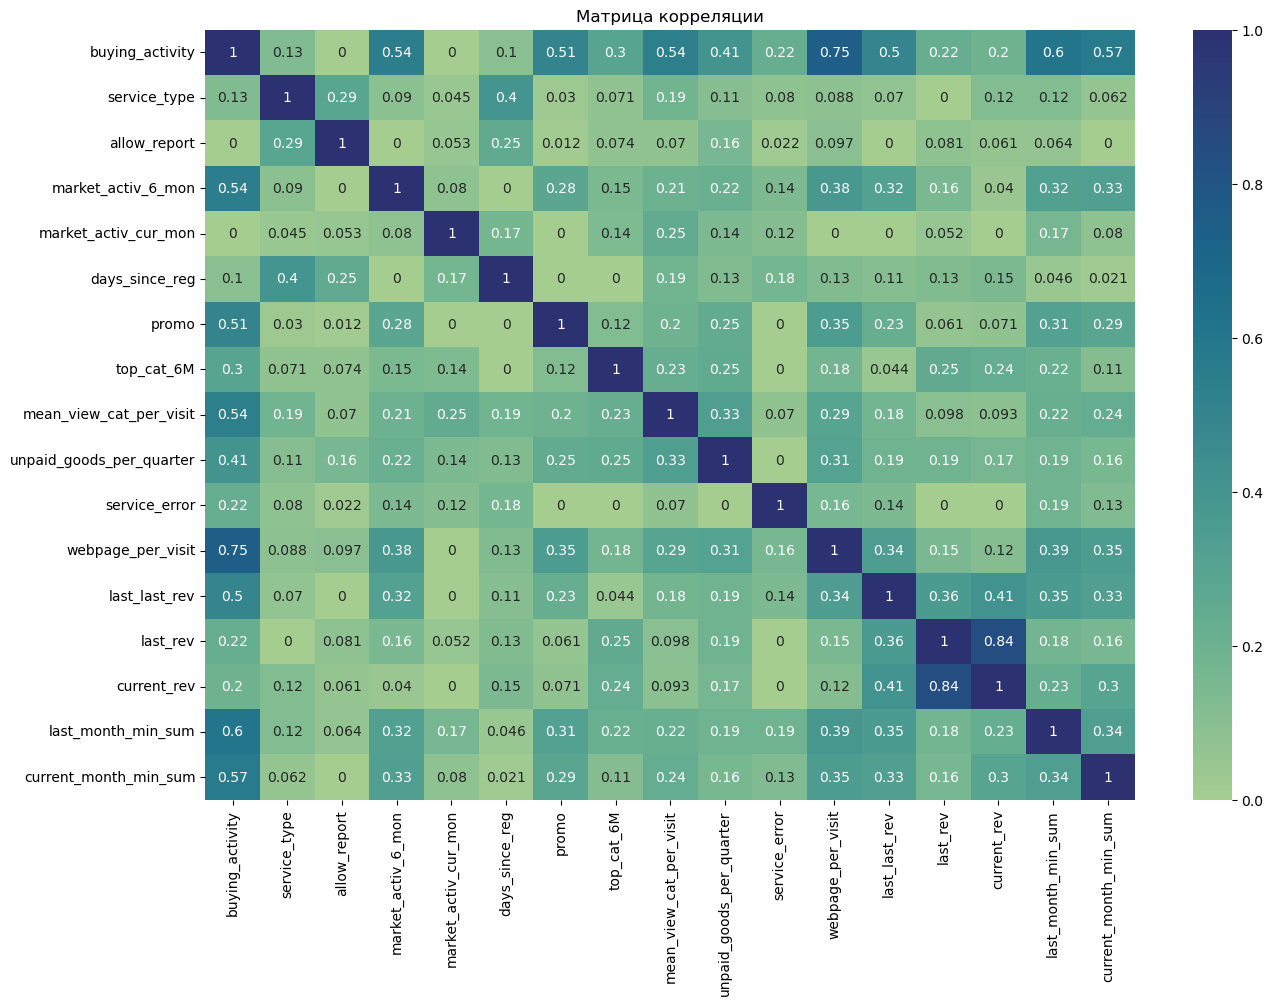

In [102]:
plt.figure(figsize=(15, 10))
sns.heatmap(phik_correlation, annot=True, cmap='crest')
plt.title('Матрица корреляции');

**Вывод:**    
Мы построили матрицу корреляции, чтобы определить присутствие мультиколлинеарности признаков. В глаза бросается только высокая корреляция признаков `last_rev` и `current_rev`, которые не будут использоваться в обучении модели.

## Использование пайплайнов

Создадим константы, поделим данные на выборки, выведем размер выборок.

In [106]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X=df.drop(['buying_activity'], axis=1)
y=df['buying_activity']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

display(X_train.head())
X_train.shape, X_test.shape

,service_type,allow_report,market_activ_6_mon,market_activ_cur_mon,days_since_reg,promo,top_cat_6M,mean_view_cat_per_visit,unpaid_goods_per_quarter,service_error,webpage_per_visit,last_last_rev,last_rev,current_rev,last_month_min_sum,current_month_min_sum
id,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,16,4347.0,5170.5,6014.2,20,6
215361,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,4597.0,6400.0,3789.7,11,13
215884,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,11,4626.0,4113.0,3798.4,13,10
216564,стандарт,да,5.6,4,342,0.94,Кухонная посуда,2,7,5,8,5269.0,4930.0,4766.2,14,19
215715,премиум,да,3.6,5,873,0.39,Товары для детей,3,2,2,5,4691.0,3716.0,4600.0,10,10


((972, 16), (324, 16))

Выведем информацию о тренировочной выборке, чтобы определить наиболее подходящую метрику.

In [108]:
y_train.value_counts()

buying_activity
Прежний уровень    601
Снизилась          371
Name: count, dtype: int64

Данных с целевым классом `Прежний уровень` почти вдвое больше, чем с целевым классов `Снизилась`. Поэтому было принято решение использовать метрику `roc-auc` для определения лучшей модели, так как она больше подходит для таких данных.

Создаём списки с названиями признаков.

In [111]:
ohe_columns = ['allow_report', 'top_cat_6M']
ord_columns = ['service_type']
num_columns = ['market_activ_6_mon' , 'market_activ_cur_mon', 'days_since_reg', 'promo', 
               'mean_view_cat_per_visit', 'unpaid_goods_per_quarter', 'service_error', 
               'webpage_per_visit', 'last_last_rev', 'last_rev','current_rev',
               'last_month_min_sum', 'current_month_min_sum']

Кодируем целевой признак с помощью `LabelEncoder`.

In [113]:
l_encoder = LabelEncoder()

y_train = l_encoder.fit_transform(y_train)
y_test = l_encoder.transform(y_test)
#прежний уровень = 0, снизилась = 1

Создаём пайплайны для кодирования данных двумя разными кодировщиками, в зависимости от данных. Для кодирования категориальных признаков с несколькими значениями будем использовать `OrdianalEncoder` и `OneHotEncoder` для бинарных признаков.

In [115]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        ('ohe', 
         OneHotEncoder(drop='first', handle_unknown='error')
        )
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        ('ord',  
         OrdinalEncoder(
             categories=[
                 ['премиум', 'стандарт']
             ],
             handle_unknown='use_encoded_value', 
             unknown_value=np.nan
         )
        ),
        ('simpleImputer_after_ord', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Создаём пайплайн для подготовки данных.

In [117]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Создаём итоговый пайплайн: подготовка данных и модель.

In [119]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Переходим к перебору моделей и гиперпараметров для выбора лучшей из них.

In [121]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [SVC(kernel = 'poly', probability=True, random_state = RANDOM_STATE) 
                    ],
        'models__degree': range(2,5),       
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='saga')
                  ],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

In [122]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv = 5,
    scoring = 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

randomized_search.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['allow_report',
                                                                                'top_cat_6M']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy=...
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42,
                                                                       solver='saga')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [123]:
print('Лучшая модель и её гиперпараметры:\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели (тренировочная выборка):', randomized_search.best_score_)
y_test_pred_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC (тестовая выборка): {roc_auc_score(y_test, y_test_pred_proba[:, 1])}')

Лучшая модель и её гиперпараметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['allow_report',
                                                   'top_cat_6M']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                 

**Вывод:**    
Лучшей моделью была выбрана модель kNN с числом соседей 17. Метрика на тренировочной выборке составила 0,90, на тестовой выборке 0,92.

## Анализ важности признаков

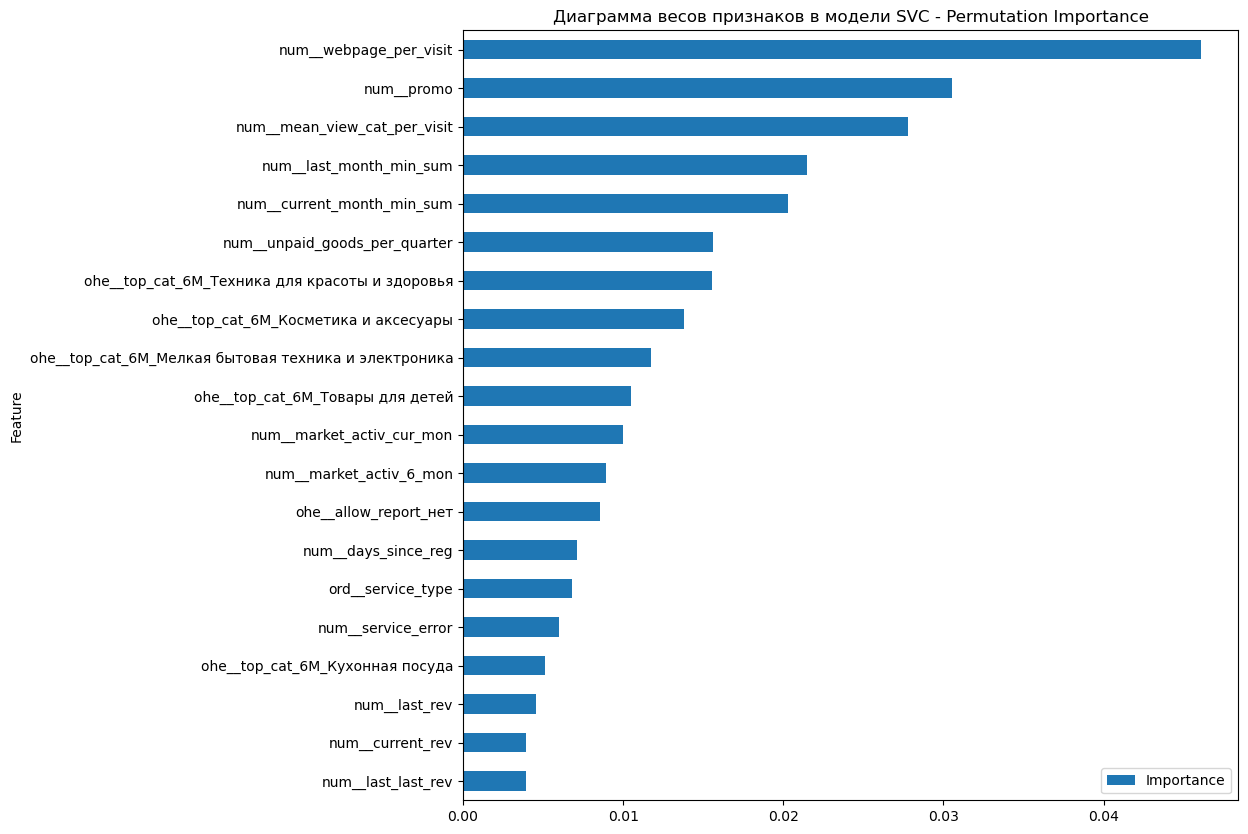

In [126]:
X_train_1 = pd.DataFrame(data_preprocessor.fit_transform(X_train),
                         columns=data_preprocessor.get_feature_names_out())

X_test_1 = pd.DataFrame(data_preprocessor.transform(X_test),
                        columns=data_preprocessor.get_feature_names_out())

svc_model = SVC(kernel='poly', random_state=RANDOM_STATE, probability=True)
svc_model.fit(X_train_1, y_train)

result = permutation_importance(svc_model, X_train_1, y_train, n_repeats=10, random_state=RANDOM_STATE)
importance = result.importances_mean

feature_importance = pd.DataFrame({'Feature': X_train_1.columns, 'Importance': np.abs(importance)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 10))

plt.title('Диаграмма весов признаков в модели SVC - Permutation Importance')
plt.show()

На построенной визуализации видно, что наибольшее влияние на вероятность снижения покупательной активности оказывают следующие признаки:

1. cреднее количество страниц, просмотренное пользователем за одно посещение сайта (`webpage_per_visit`);
2. доля товаров по акции от всех приобритенных пользователем товаров (`promo`);
3. среднее количество просмотренных категорий за одно посещение сайта (`mean_view_cat_per_visit`);
4. время, проведенное на сайте в прошлом месяце (`last_month_min_sum`);
5. время, проведенное на сайте в текущем месяце (`current_month_min_sum`);
6. количество неоплаченных товаров в корзине (`unpaid_goods_per_quarter`).

In [128]:
main_features = ['webpage_per_visit', 'mean_view_cat_per_visit', 
    'last_month_min_sum', 'current_month_min_sum', 'promo', 'unpaid_goods_per_quarter']

Построим SHAP визуализацию для важности признаков.

PermutationExplainer explainer: 973it [02:25,  6.27it/s]                        


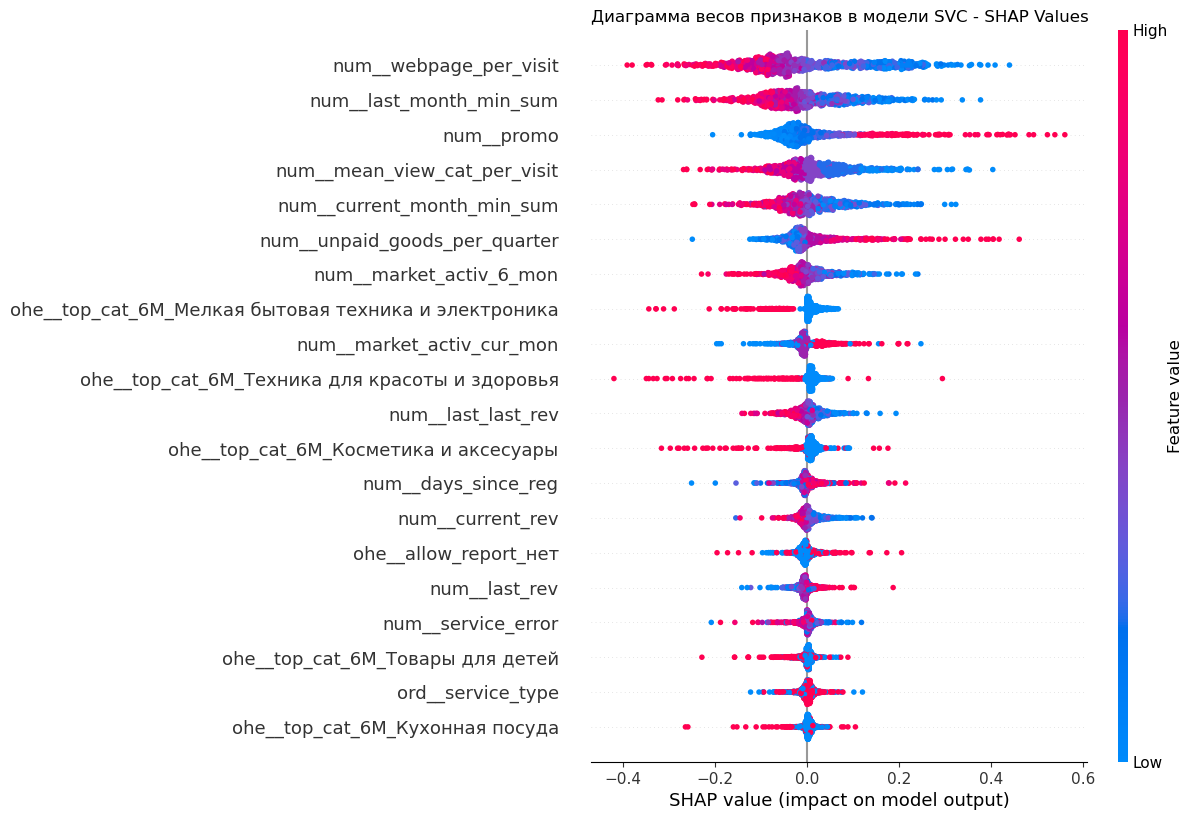

In [130]:
explainer = shap.Explainer(svc_model.predict, X_train_1)
shap_values = explainer(X_train_1)

plt.title('Диаграмма весов признаков в модели SVC - SHAP Values')
shap.plots.beeswarm(shap_values,max_display=20)

Построенная визуализация показывает, что 
- чем меньше страниц и категорий просматривал пользователь за посещение (`webpage_per_visit`, `mean_view_cat_per_visit`), а также чем меньше времени пользователь проводил на сайте за одно посещение в прошлом и текущем месяце (`last_month_min_sum`, `current_month_min_sum`), тем выше вероятность предсказания снижения покупательной активности;
- чем выше доля покупок по акции (`promo`), тем выше вероятность предсказания снижения покупательной активности;
- чем больше неоплаченных товаров в корзине пользователя за последний квартал (`unpaid_goods_per_quarter`), тем выше вероятность предсказания снижения покупательной активности.

Кроме того,
- чем *меньше* среднее количество маркетинговых коммуникаций полученных пользователем за последние *6 месяцев*, тем выше вероятность  предсказания снижения покупательной активности;
- однако, чем *больше* количество коммуникаций, полученных пользователем за текущий месяц, тем выше вероятность  предсказания снижения покупательной активности.

**Вывод**:

Наиболее важными признаками для определения вероятности снижения покупательной активности пользователей являются
- cреднее количество страниц, просмотренное пользователем за одно посещение сайта;
- доля товаров по акции от всех приобретённых пользователем товаров;
- среднее количество просмотренных категорий за одно посещение сайта;
- время, проведенное на сайте в прошлом месяце и в текущем месяце;
- количество неоплаченных товаров в корзине.

Положительно влияют на вероятность пользователя не уменьшить свою покупательную активность среднее количество страниц и категорий просмотренных за одно посещение, а также время, проведенное на сайте за текущий и предыдущий месяц.

Отрицательно влияют на вероятсность сохранения покупательной активности доля товаров по акции и количество неоплаченных товаров в корзине за последний квартал.

Интересная зависимость наблюдается для маркетинговых коммуникаций. Чем меньше среднее количество маркетинговых коммуникаций полученных пользователем *за последние 6 месяцев*, тем выше вероятность снижения покупательной активности, однако чем меньше количество коммуникаций, полученных пользователем за *текущий месяц*, тем эта вероятность ниже.

## Сегментация пользователей

In [134]:
all_proba = randomized_search.predict_proba(df.drop('buying_activity', axis=1))

In [135]:
df['proba'] = all_proba[:,1]

In [136]:
money = money.set_index('id')

In [137]:
df_all = df.join(money, how='inner')

/var/folders/_t/38zrcwqn0wg8759pyl0gzz1c0000gn/T/ipykernel_24160/1166083550.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


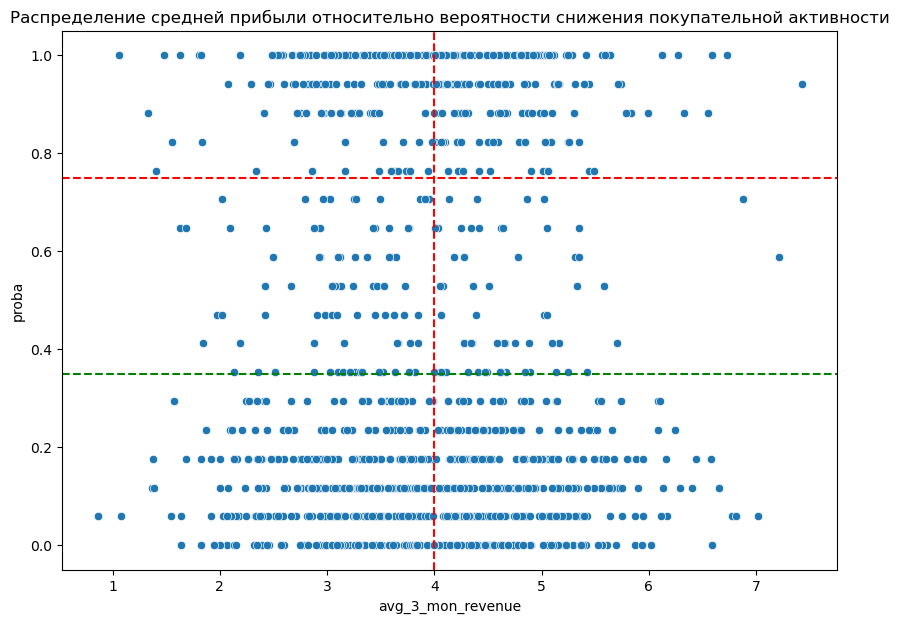

In [138]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(
    x=df_all['avg_3_mon_revenue'],
    y=df_all['proba'], 
    data=df_all,
    palette='bright');
plt.axvline(4, color='r', linestyle='--')
plt.axhline(0.75, color='r', linestyle='--')
plt.axhline(0.35, color='g', linestyle='--')
plt.title('Распределение средней прибыли относительно вероятности снижения покупательной активности');

Для дальнейшей работы выделим сегмент пользователей, который приносит прибыль выше средней, и имеет высокую (выше 75%) вероятность снижения покупательной активности. Этот сегмент находится в правом верхнем углу диаграммы. Потеря данного сегмента наиболее опасна, т.к. указанные пользователи приносят магазину высокую прибыль. Удержание данного сегмента позволит сохранить максимальную прибыль без привлечения новых клиентов. 

*Другой интересный для работы сегмент **(который не будет рассмотрен в данной работе)**: клиенты, покупательная активность которых с большой вероятностью останется прежней, но которые при этом приносят невысокую прибыль. Этот сегмент находится в левом нижнем углу диаграммы. Если увеличить вовлеченность данного сегмента и тем самым поднять его прибыльность для компании, общая прибыль магазина так же будет увеличиваться.*

Оценим величину выбранного сегмента и постоим графики распределения прибыльности относительно вероятности снижения активности с учетом параметров, определенных моделью как "важные".

In [141]:
segment_of_interest = df_all[(df_all['proba'] >= 0.75)&(df_all['avg_3_mon_revenue']>4)]

In [142]:
print('величина сегмента: ', len(segment_of_interest)
      , '\nдоля сегмента: ', round(len(segment_of_interest)/len(df),2), '%', sep='')

величина сегмента: 182
доля сегмента: 0.14%


In [143]:
def scatterplots_by_features(df, first_feature, second_feature, features):
    fig, ax = plt.subplots(figsize=(10,50))
    counter = 0
    for feature in features:
        counter += 1
        plt.subplot(len(features), 1, counter)
        sns.scatterplot(
            x=first_feature,
            y=second_feature, 
            data=df,
            palette='coolwarm',
            hue=feature);
        plt.axvline(4, color='r', linestyle='--')
        plt.axhline(0.75, color='r', linestyle='--')
        plt.title('Распределение средней прибыльности клиента относительно вероятности снижения активности \n' +
                 f'(с учётом {feature})')

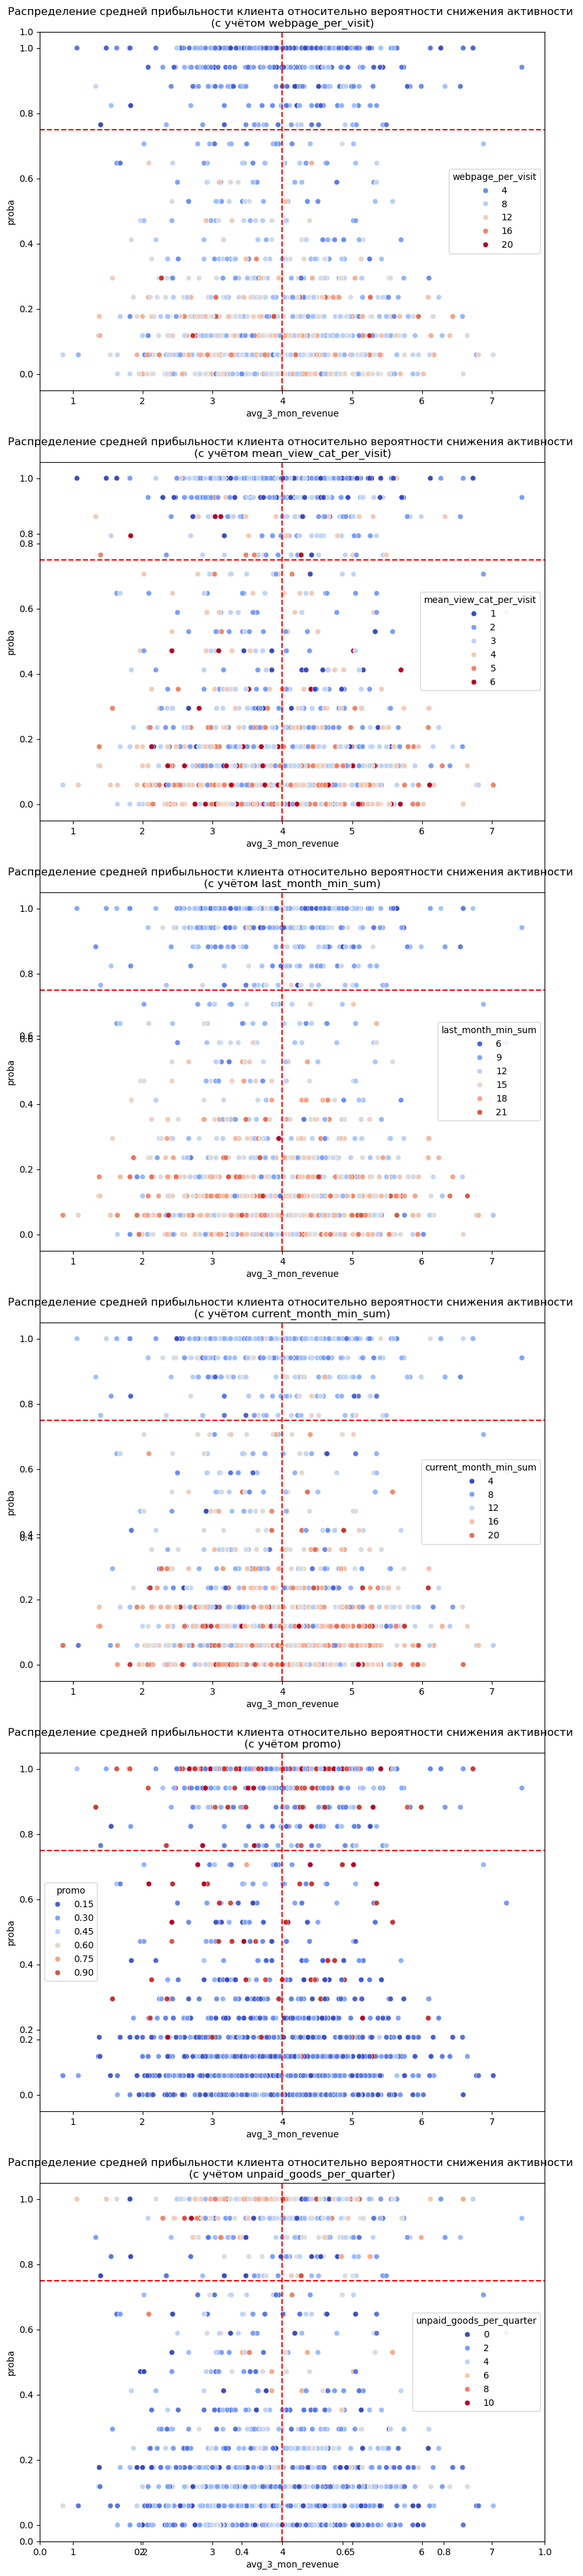

In [144]:
scatterplots_by_features(df_all, 'avg_3_mon_revenue', 'proba', main_features)

На графиках видно, что в выбраном сегменте, в сравнении с аналогичным по прибыльности сегментом с низкой вероятностью снижения активности
-  невысокие показатели вовлеченности клиентов: среднее количество посещенных страниц и просмотренных категорий за визит, а так же среднее время проведенное на сайти в этом сегменте ниже;
- средняя доля покупок по акции выше;
- среднее количество неоплаченных товаров в корзине выше.

Посмотрим также на остальные признаки, представленные в датафрейме, чтобы проверить, можно ли построить какие-либо рекомендации на основе этих данных.
Построим аналогичные графики распределений.

In [147]:
other_features = set(df_all.columns) - set(main_features) - set(['buying_activity'
                                    , 'proba', 'avg_3_mon_revenue', 'current_rev', 'last_last_rev', 'last_rev'])
other_features = ['allow_report',
 'days_since_reg',
 'market_activ_6_mon',
 'market_activ_cur_mon',
 'service_error',
 'service_type',
 'top_cat_6M']

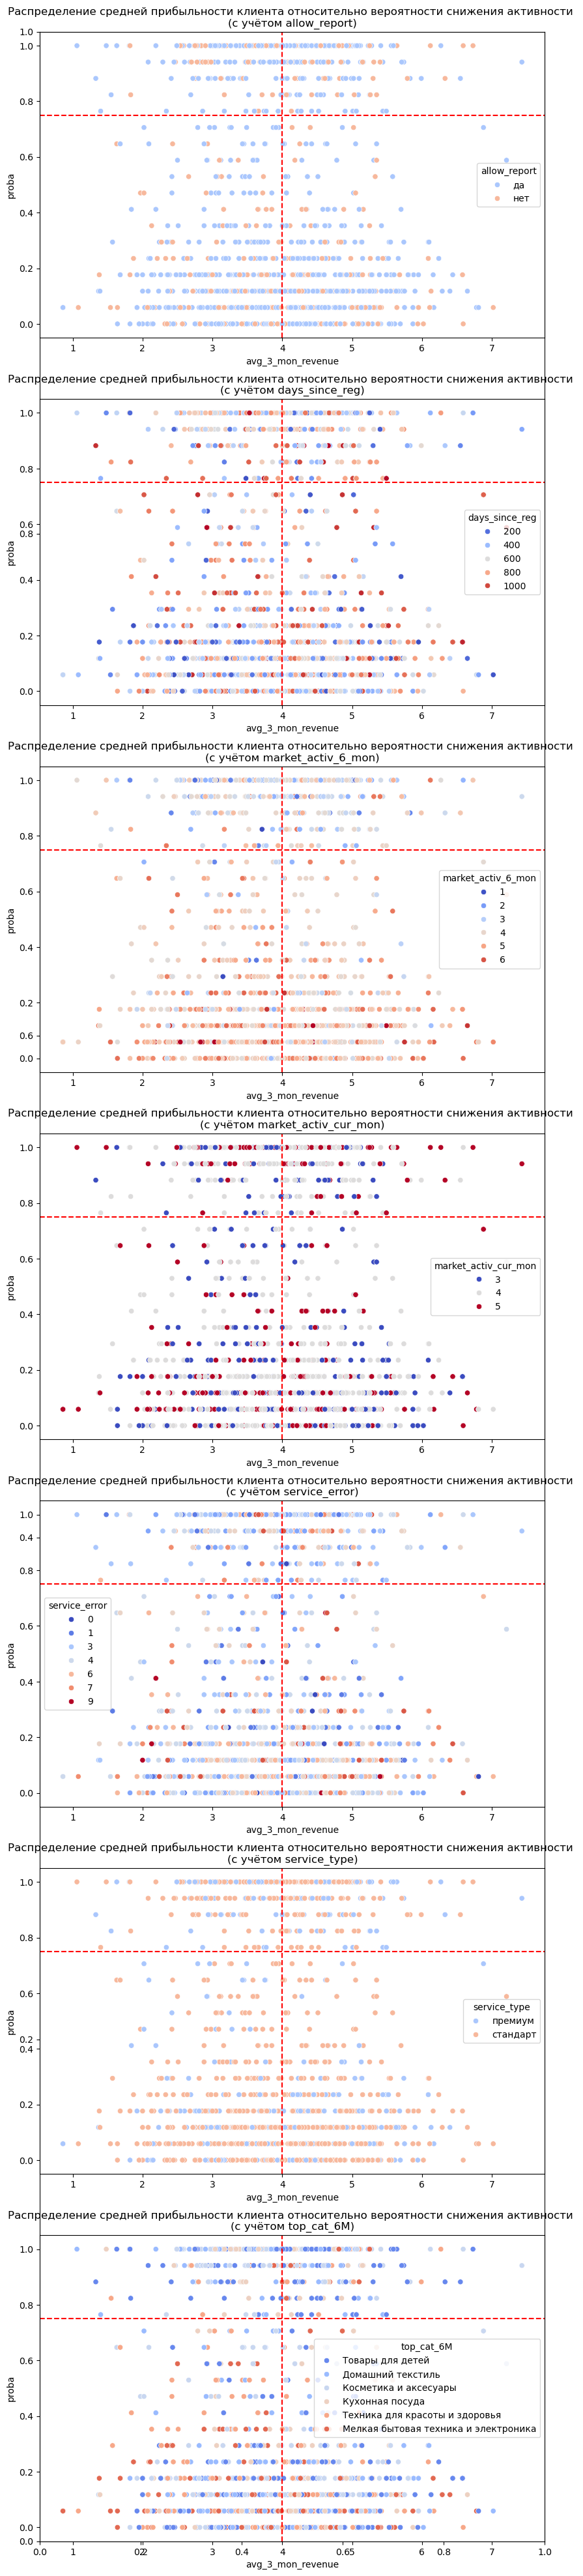

In [148]:
scatterplots_by_features(df_all, 'avg_3_mon_revenue', 'proba', other_features)

На графиках видно, что:

- среди различных сегментов нет существенной разницы между долями клиентов, разрешивших и не разрешивших уведомления о товарах;
- в выбранном сегменте чуть чаще наблюдаются относительно "молодые" клиенты и не так много "старых", в сравнении с аналогичным по прибыльности сегментом с меньшей вероятностью снижения активности;
- для выбранного сегмента характерно получение в среднем не более 4х маркетинговых коммуникаций за последние 6 месяцев, что в среднем меньше, чем для аналогичного по прибыльности сегмента с меньшей вероятностью снижения активности;
- при этом среди клиентов выбранного сегмента, в особенности клиентов с вероятностью снижения активности близкой к 1, выделяются клиенты, получившие 5 маркетинговых коммуникаций в текущем месяце;
- существенных различий между количеством ошибок сайта на пользователя среди сегментов не наблюдается. Аналогично с типом сервиса доступным пользователю;
- относительно типа категорий можно отметить, что пользователи в выбранном сегменте реже совершают покупки в категориях "Техника для красоты и здоровья" и "Мелкая бытовая техника и электроника".

**Вывод и рекомендации:**

***Выбранный сегмент пользователей***: *покупатели с высокой прибылью для компании (выше средней) и высокой вероятностью снижения покупательной активности (75% и выше).*

Потеря данного сегмента наиболее опасна, т.к. указанные пользователи приносят магазину высокую прибыль. Удержание данного сегмента позволит сохранить максимальную прибыль без привлечения новых клиентов.

На основе проведенного анализа для увеличения вовлеченности выбранного сегмента можно предложить следующие шаги.
- Увеличить вовлечённость сегмента (количество просмотренных страниц, время на сайте, количество категорий за визит) путём показа релевантных рекомендаций. Важно убедиться в релевантности рекомендаций, чтобы не достичь обратного эффекта показом большого количества не интересных пользователю товаров.
- Настроить коммуникацию, напоминающую пользователю о неоплаченных товарах в корзине. Протестировать напоминания по различным каналам, а также рассмотреть напоминания в момент, когда на товар появляется скидка, или напоминания с небольшой дополнительной скидкой на наиболее релевантный товар в корзине. Важно соблюсти баланс по частоте напоминаний, и размеру скидок. Этот баланс может быть найден с помощью проведения АВ-тестирования.
- Обратить внимание на пользователей, покупающих бòльшую часть товаров по акции. Этот сегмент пользователей должен быть дополнительно проанализирован для установки причин такого поведения. Например, возможно, что пользователи не доверяют магазину достаточно, чтобы покупать дорогие товары. В таком случае необходимо проводить работу с репрезентацией самого магазина среди этой группы, в том числе путем показа релевантных товаров с высокими оценками других клиентов.
- Обратить внимание на "молодых" клиентов: провести анализ метрики retention, найти AHA моменты пользователей и целенаправленно подводить новых пользователей к этим моментам в более короткие сроки. 
- Пересмотреть политику маркетинговых коммуникаций: по анализу выше можно предположить, что многие пользователи в сегменте получали недостаточно коммуникаций в течение полугода, и получили значительно больше коммуникаций в текущем месяце. Такая стратегия коммуникаций может "отпугивать" пользователей и вызывать раздражение. Данный вопрос следует изучить глубже и провести АВ-тестирование для проверки гипотез.
- Увеличить видимость категорий "Техника для красоты и здоровья" и "Мелкая бытовая техника" среди пользователей выбранного сегмента. Кроме видимости этих категорий стоит работать над доверием пользователей к магазину и представленным товарам, т.к. отказ от покупки техники может говорить о том, что пользователь недостаточно уверен в надежности товара и/или магазина. Повысить уровень доверия могут как более видимые отзывы и оценки других покупателей (рекомендация релевантного товара с подчеркиванием высокого рейтинга и хороших отзывов с помощью UI), так вовлечение в маркетинг "значимых фигур", вызывающих доверие: релевантных для данной группы звезд, блогеров, брендов. 

**Таким образом, для удержания данного сегмента клиентов имеет смысл рекомендательная система с высоким уровнем релевантности товаров и правильным UI, дополненная маркетинговыми коммуникациями правильной частоты. "Правильность" должна определяться поэтапным тестированием и анализом метрик.**

## Общий вывод

В контексте проекта для интернет-магазина "В один клик", который сталкивается с снижением активности покупателей, целью стажировки в отделе цифровых технологий является разработка решения для удержания постоянных клиентов путем персонализации предложений.

В связи с тем, что привлечение новых клиентов становится менее эффективным, руководство магазина пришло к выводу, что более эффективным подходом будет удержание уже существующей аудитории. Для этого было предложено использовать персонализированные предложения, анализируя данные о покупках и предпочтениях клиентов.

Основная задача заключалась в построении модели, предсказывающей вероятность снижения покупательной активности клиента в следующие три месяца и определении параметров, наиболее сильно на это влияющих. На основе проведенного анализа и данных о прибыльности клиентов требовалось провести сегментацию пользователей и предложить варианты увеличения их покупательной активности.

Для исследования были представлены четыре датасета с различными данными о клиентах:

`market_file.csv`    
`market_money.csv`    
`market_time.csv`    
`money.csv`

**Цель проекта:** увеличить покупательскую активность постоянных клиентов путем предоставления им персонализированных предложений, что в конечном итоге должно привести к увеличению выручки интернет-магазина "В один клик".

**Ход исследования:**

1. **Предобработка данных**

Все параметры были проверены на наличие пропусков в данных и дубликатов. В процессе были удалены неявные дубликаты в поле "тип сервиса" в файле `market_file`, а также проверены типы данных – все поля имеют удобный для дальнейшей работы тип данных. Таблицы приведены к удобному формату.

2. **Исследовательсий анализ данных**

Данные были проверены на аномальные значения. Был удалён один выброс в поле "прибыль" из файла `market_money`. Также мы убедились, что распределения всех остальных параметров выглядят реалистично и не требуют дополнительной чистки данных.
После предобработки мы объединили таблицы с данными о клиентах и отобрали для дальнешей работы только записи о тех клиентах, которые совершали какие-либо покупки за последние 3 месяца. 

3. **Корреляционный анализ данных**

Был проведён корреляционный анализ входных признаков с целью обнаружения мультиколлинеарности. Выссокая корреляция наблюдалась только между признаками, `last_rev` и `current_rev`, которые не использовались в обучении модели.

4. **Создание пайплайнов**
Для более удобного применения различных моделей кодировщиков и скейлеров были построены пайплайны обработки данных и обучения моделей. 

5. **Выбор лучшей модели и её гиперпараметров**

На основе выбранной метрики качества `roc-auc` лучшей моделью была признана модель kNN с числом соседей 17. На тренировочной выборке модель показала результат 90 процентов, на тестовой выборке - 0,92.

6. **Анализ важности признаков**
Наиболее важными признаками для определения вероятности снижения покупательной активности пользователей с помощью модели, указанной выше, являются:
- cреднее количество страниц, просмотренное пользователем за одно посещение сайта;
- доля товаров по акции от всех приобритенных пользователем товаров;
- среднее количество просмотренных категорий за одно посещение сайта;
- время, проведенное на сайте в прошлом месяце и в текущем месяце;
- количество неоплаченных товаров в корзине.

Среднее количество страниц и категорий просмотренных за одно посещение, а также время, проведенное на сайте за текущий и предыдущий месяц положительно влияют на сохранение покупательской активности пользователей. Количество неоплаченных заказов и доля покупок по акциям влияют отрицательно.

7. **Сегментация покупателей**

Сегмент пользователей был выбран следующий: покупатели с высокой прибылью для компании (выше средней) и высокой вероятностью снижения покупальтельной активности (75% и выше).

Потеря данного сегмента наиболее опасна для бизнеса, т.к. указанные пользователи приносят магазину высокую прибыль. Удержание данного сегмента позволит сохранить максимальную прибыль без привлечения новых клиентов.

По результатам анализа можно предложить следующие шаги:

- Увеличить вовлеченность пользователей из сегмента (количество просмотренных страниц, время на сайте, количество категорий за визит) путём показа релевантных рекомендаций. Важно убедиться в релевантности рекомендаций, чтобы не достичь обратного эффекта показом большого количества не интересных пользователю товаров.
- Настроить коммуникацию, напоминающую пользователю о неоплаченных товарах в корзине. Протестировать напоминания по различным каналам, а также рассмотреть напоминания в момент, когда на товар появляется скидка, или напоминания с небольшой дополнительной скидкой на наиболее релевантный товар в корзине. Важно соблюсти баланс по частоте напоминаний, и размеру скидок. Этот баланс может быть найден с помощью проведения АВ-тестирования.
- Обратить внимание на пользователей, покупающих бòльшую часть товаров по акции. Этот сегмент пользователей должен быть дополнительно проанализирован для установки причин такого поведения. Например, возможно, что пользователи не доверяют магазину достаточно, чтобы покупать дорогие товары. В таком случае необходимо проводить работу с репрезентацией самого магазина среди этой группы, в том числе путем показа релевантных товаров с высокими оценками других клиентов.
- Обратить внимание на "молодых" клиентов: провести анализ метрики retention, найти AHA моменты пользователей и целенаправленно подводить новых пользователей к этим моментам в более короткие сроки. 
- Пересмотреть политику маркетинговых коммуникаций: по анализу выше можно предположить, что многие пользователи в сегменте получали недостаточно коммуникаций в течение полугода, и получили значительно больше коммуникаций в текущем месяце. Такая стратегия коммуникаций может "отпугивать" пользователей и вызывать раздражение. Данных вопрос следуюет изучить глубже и провести АВ-тестирование для проверки гипотез.
- Увеличить видимость категорий "Техника для красоты и здоровья" и "Мелкая бытовая техника" среди пользователей выбранного сегмента. Кроме видимости этих категорий стоит работать над доверием пользователей к магазину и представленным товарам, т.к. отказ от покупки техники может говорить о том, что пользователь не достаточно уверен в надежности товара и/или магазина. Повысить уровень доверия могут как более видимые отзывы и оценки других покупателей (рекомендация релевантного товара с подчеркиванием высокого рейтинга и хороших отзывов с помощью UI), так вовлечение в маркетинг "значимых фигур", вызывающих доверие: релевантных для данной группы звезд, блоггеров, брендов.